# Opinion Mining with Big Data

Enter a topic. See what people say about it on Twitter, in real time.
1. Set up environment
2. Stream from Twitter
3. Visualize tweets

## 1. Set Up Environment

In [0]:
# Ask for topic in Databricks
dbutils.widgets.text('topic', 'Omicron', 'What people are talking about:')
topic = dbutils.widgets.get('topic')

# Ask for topic in other environments
# topic = input('Enter a topic: ')

# Or run without asking for input
# topic = 'Omicron'

topic = topic.lower().strip()
print('The topic is ' + topic)

The topic is omicron

In [0]:
# Turn off widget in Databricks if not in used
# dbutils.widgets.removeAll()

In [0]:
# Install modules
!pip install tweepy -q --disable-pip-version-check
!pip install nltk -q --disable-pip-version-check
!pip install wordcloud -q --disable-pip-version-check

In [0]:
# Install Spark NLP if Jupyter Notebook is used
# pip install spark-nlp==3.4.0

# Install Spark NLP if Google Colab is used
# !wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

# Install Spark NLP as per https://nlp.johnsnowlabs.com/docs/en/install if Databricks is used

In [0]:
# Import modules
import json
import tweepy
import time
from datetime import datetime
import matplotlib.pyplot as plt

from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml import Pipeline

import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
from sparknlp import Finisher

from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [0]:
# Set up NLTK module for natural language processing
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data] Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data] Package punkt is already up-to-date!
Out[50]: True

In [0]:
# Start Spark NLP and show link to Spark UI
spark = sparknlp.start()
spark

Out[51]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.2 
 Master 
 spark://10.156.246.51:7077 
 AppName 
 Databricks Shell

In [0]:
# Load pipeline for sentiment analysis
# https://nlp.johnsnowlabs.com/2021/01/18/analyze_sentimentdl_use_twitter_en.html
print('Loading pipeline for sentiment analysis...')

# Load pipeline from memory if available
if 'pipeline_sentiment' in globals():
    print('Pipeline for sentiment analysis loaded from memory')
else:
    # Or download pipeline from Spark NLP server
    pipeline_sentiment = PretrainedPipeline("analyze_sentimentdl_use_twitter", lang = "en") 
        
print(pipeline_sentiment)

Loading pipeline for sentiment analysis...
Pipeline for sentiment analysis loaded from memory
<sparknlp.pretrained.PretrainedPipeline object at 0x7f76fcc31a30>

In [0]:
# Load pipeline for emotion analysis
# https://nlp.johnsnowlabs.com/2021/11/21/distilbert_sequence_classifier_emotion_en.html
print('Loading pipeline for emotion analysis...')

# Try to load pipeline from memory
if 'pipeline_emotion' in globals():
    print('Pipeline for emotion analysis loaded from memory')
else:
    # Download pipeline from Spark NLP server
    document_assembler = DocumentAssembler() \
        .setInputCol('text') \
        .setOutputCol('document')

    tokenizer = Tokenizer() \
        .setInputCols(['document']) \
        .setOutputCol('token')

    sequenceClassifier = DistilBertForSequenceClassification \
          .pretrained('distilbert_sequence_classifier_emotion', 'en') \
          .setInputCols(['token', 'document']) \
          .setOutputCol('class') \
          .setMaxSentenceLength(512)

    pipeline_emotion = Pipeline(stages=[
        document_assembler, 
        tokenizer,
        sequenceClassifier    
    ])
    
    print('Pipeline for emotion analysis downloaded from server')

print(pipeline_emotion)

Loading pipeline for emotion analysis...
Pipeline for emotion analysis loaded from memory
Pipeline_b23e51fdc66d

In [0]:
# Twitter developer account credentials (use your own)
consumer_key = 'mWTEf1dCKQbyc1trrd0lzvsrn'
consumer_secret = 'NJEbzBemHcoC1crn7Mioo6aut70VsvP8vhdeeRMZmSUYjvZQXX'
access_token = '9618812-MVKlOl4WDy1Tr4cGhIjGwp60wrH8hI4cf3KRUVmaDw'
access_token_secret = '77AImSbrh9PyorLlPM2xvZH0aJfcy53bfwyrz99cxfjhY'

In [0]:
# Authenticate credentials with Twitter
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [0]:
# Location used to store tweets on DBFS
path = '/FileStore/tweets/' + datetime.now().strftime('%Y%m%d%H%M%S') + '/'
dbutils.fs.mkdirs(path)
print('Location to save tweets: ' + path)

Location to save tweets: /FileStore/tweets/20220119135838/

## 2. Stream From Twitter

In [0]:
# A function to convert date in Twitter format to Spark timestamp format
def ConvertDate(tweet_date):
    return datetime.strftime(datetime.strptime(tweet_date,'%a %b %d %H:%M:%S +0000 %Y'), '%Y-%m-%d %H:%M:%S')

In [0]:
# A function to get the sentiment of a text using pre-trained pipeline
def GetSentiment(text):
    data = spark.createDataFrame([[text]]).toDF('text')
    result = pipeline_sentiment.transform(data)
    sentiment = result.select('sentiment.result').select('result').collect()[0][0][0].title()
    return sentiment

In [0]:
# A function to get the sentiment of a text using pre-trained pipeline
def GetEmotion(text):
    data = spark.createDataFrame([[text]]).toDF('text')
    result = pipeline_emotion.fit(data).transform(data)
    emotion = result.select('class.result').collect()[0][0][0].title()
    return emotion

In [0]:
# A function to retrieve relevant parts of a tweet and save the tweets in JSON format
def SaveTweet(tweet):
    # Process only tweets that are not empty and not retweeted
    if tweet and ('retweeted_status' not in tweet) and topic in tweet['text'].lower():
        out = {}
        out['ID'] = tweet['id']
        out['Created'] = ConvertDate(tweet['created_at'])
        out['User'] = tweet['user']['screen_name']
        out['Tweet'] = tweet['text']
        out['Sentiment'] = GetSentiment(tweet['text'])
        out['Emotion'] = GetEmotion(tweet['text'])
        
        filename = str(tweet['id']) + '.json'
        with open('/dbfs' + path + filename, 'w') as outfile:
            json.dump(out, outfile)

In [0]:
# A class to specify what to do upon certain events
class TweetStream(tweepy.Stream):        
    def on_connection_error(self):
        print('Disconnecting...')
        self.disconnect()
    
    def on_data(self, data):
        current_tweet = json.loads(data)
        SaveTweet(current_tweet)
        
    def on_status(self, status):
        pass

In [0]:
# Start streaming from Twitter
tweets = TweetStream(
  consumer_key, consumer_secret,
  access_token, access_token_secret
)

In [0]:
# Real time tweets are retrieved based on selected topic. Get English tweets only. Run in separate thread.
thread_tweets = tweets.filter(track=[topic], languages=['en'], threaded=True)

In [0]:
# Confirm the stream is running
tweets.running

Out[64]: True

In [0]:
# Define the JSON schema
jsonSchema = StructType([
    StructField('ID', StringType(), True), # Tweet ID
    StructField('Created', TimestampType(), True), # Tweet creation time
    StructField('User', StringType(), True), # Twitter user screen name
    StructField('Tweet', StringType(), True), # Tweet text
    StructField('Sentiment', StringType(), True), # Sentiment of tweet
    StructField('Emotion', StringType(), True) # Emotion of tweet
])

In [0]:
# Stream tweets from DBFS directory
streamingInputDF = (
  spark
    .readStream                       
    .schema(jsonSchema)
    .option("maxFilesPerTrigger", 1)
    .json(path)
)

# Confirm the stream is running
streamingInputDF.isStreaming

Out[66]: True

In [0]:
streamingInputDF.createOrReplaceTempView("QueryTweets")

In [0]:
# Reduce the size of shuffles from the default 200
spark.conf.set('spark.sql.shuffle.partitions', '2')

In [0]:
# Confirm tweets are stored in directory
dbutils.fs.ls(path)

Out[69]: []

## 3. Visualize Tweets

Table - Show the tweets.

In [0]:
%sql
SELECT *
FROM QueryTweets

-- Equivalent code in PySpark
-- df_tweets = spark.sql('SELECT * FROM QueryTweets')
-- df_tweets.display()

ID,Created,User,Tweet,Sentiment,Emotion
1483801058329649155,2022-01-19T13:58:34.000+0000,kmvnarayan14,"A question that many have asked: “Will the #Omicron wave deliver #immunity to most of the world’s population, eithe… https://t.co/dxWIYS47rV",Positive,Joy
1483801064130363399,2022-01-19T13:58:36.000+0000,VirasthNews,Omicron surge shows signs of easing in states hit early by the fast-spreading variant https://t.co/b34aOuSLBX,Negative,Joy
1483801080664371206,2022-01-19T13:58:39.000+0000,ronnocer,"@MayorNorton Omicron is mild. You’re a shitty mayor. If you’re afraid of it. Bunker the fuck at home, wear your fuc… https://t.co/ZuXfXdhhpC",Positive,Fear
1483801109885906945,2022-01-19T13:58:46.000+0000,LRomantz,@Statgeneral @paulkrugman Do some reading on what caused the Delta and Omicron variants to spread.,Positive,Anger
1483801134531850249,2022-01-19T13:58:52.000+0000,AChandra_TO,@gregbradyTO The UK navigated the Omicron wave with the least restrictions of any European country (just reinstitut… https://t.co/IEeWdQAon7,Negative,Joy
1483801137207824387,2022-01-19T13:58:53.000+0000,jeguru1,COVID-19 in Europe: Record case numbers in France and Germany as Omicron spreads https://t.co/9XDr0KjWCx,Negative,Fear
1483801137891491843,2022-01-19T13:58:53.000+0000,sakaerka,Meanwhile in #Europe: “Record-breaking Omicron wave sweeps across Europe https://t.co/LuviGZxXAY,Neutral,Joy
1483801158389018626,2022-01-19T13:58:58.000+0000,EdGillard1,"@ClaireCopperman @Femi_Sorry While the world is grappling with the highly infectious Omicron, strain of Covid, scie… https://t.co/G9358pZCE9",Positive,Joy
1483801161312477189,2022-01-19T13:58:59.000+0000,ChristineEasda1,All metrics are falling. Daily ups and downs sometimes reflect reporting hold ups and backlog dumps. Omicron is the… https://t.co/muxZpJHwBr,Negative,Fear
1483801165506568197,2022-01-19T13:59:00.000+0000,Elizabe14767650,#COVID19 #COVID-19 #COVID #Omicron Knew they were hiding something fishy at Fort Detrick. The smallpox virus that w… https://t.co/BdiTGXizC0,Negative,Fear


Visualization #1 - Show the sentiments of the tweets in bar chart.

In [0]:
%sql
SELECT Sentiment, count(*) AS Count 
FROM QueryTweets 
GROUP BY Sentiment 
ORDER BY 
  CASE 
    WHEN Sentiment = "Negative" THEN 1 
    WHEN Sentiment = "Neutral" THEN 2 
    WHEN Sentiment = "Positive" THEN 3 
  END ASC

-- Equivalent code in PySpark
-- df_sentiment = spark.sql('SELECT Sentiment, count(*) AS Count FROM QueryTweets GROUP BY Sentiment ORDER BY CASE WHEN Sentiment = "negative" THEN 1 WHEN Sentiment = "neutral" THEN 2 WHEN Sentiment = "positive" THEN 3 END ASC')
-- df_sentiment.display()

Sentiment,Count
Negative,55
Neutral,5
Positive,46


Visualization #2 - Show the sentiments of the tweets in pie chart.

In [0]:
%sql
SELECT Sentiment, count(*) AS Count 
FROM QueryTweets 
GROUP BY Sentiment 
ORDER BY 
  CASE 
    WHEN Sentiment = "Negative" THEN 1 
    WHEN Sentiment = "Neutral" THEN 2 
    WHEN Sentiment = "Positive" THEN 3 
  END ASC

Sentiment,Count
Negative,55
Neutral,5
Positive,46


Visualization #3 - Show the emotions of the tweets in bar chart.

In [0]:
%sql
SELECT Emotion, count(*) AS Count 
FROM QueryTweets 
GROUP BY Emotion 
ORDER BY Emotion

-- Equivalent code in PySpark
-- df_emotion = spark.sql('SELECT Emotion, count(*) AS Count FROM QueryTweets GROUP BY Emotion ORDER BY Emotion')
-- df_emotion.display()

Emotion,Count
Anger,19
Fear,28
Joy,50
Sadness,9


Visualization #4 - Show the emotions of the tweets in pie chart.

In [0]:
%sql
SELECT Emotion, count(*) AS Count 
FROM QueryTweets 
GROUP BY Emotion 
ORDER BY Emotion

Emotion,Count
Anger,19
Fear,29
Joy,50
Sadness,9


Visualization #5 - Show a word cloud of the tweets.

In [0]:
# Wait for tweets to come in
time.sleep(15)

In [0]:
# Create list of stop words
stopwords_en = stopwords.words('english')
stopwords_en.append('https')
stopwords_en.append('n\'t')

In [0]:
streamingInputDF.writeStream.format('memory').queryName('QueryCloud').outputMode('append').start()

Out[72]: <pyspark.sql.streaming.StreamingQuery at 0x7f76f1d47c70>

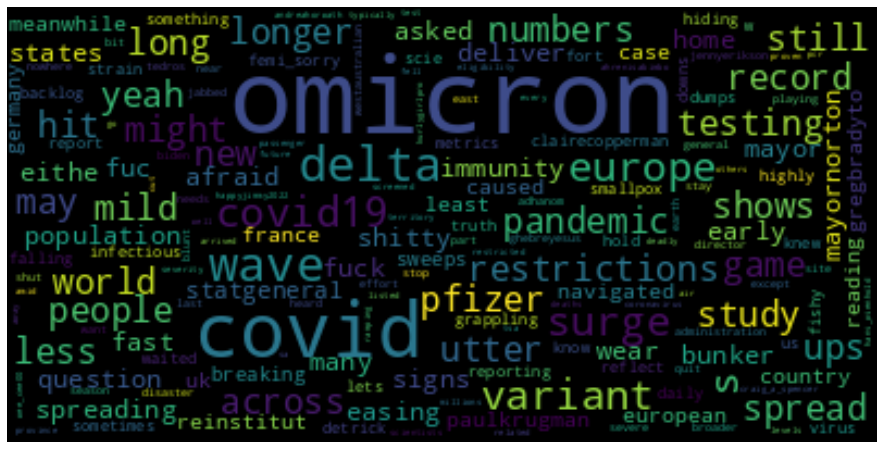

In [0]:
# Prepare content for word cloud
df_cloud = spark.sql('SELECT Tweet FROM QueryCloud')
rows = df_cloud.select('Tweet').rdd.flatMap(lambda x: x).collect()
words = word_tokenize(' '.join(rows).lower())
words = [word for word in words if word not in stopwords_en and len(word) > 1 and not word.startswith('//t.co')]
content = ' '.join(words)

if content:
    plt.figure(figsize=(16, 8))
    wordcloud = WordCloud(max_font_size=50, max_words=200, background_color='black').generate(content)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
else:
    print('No word to show yet')

In [0]:
# Wait 30 seconds then stop all streams to save data transfer
# time.sleep(30)

# tweets.disconnect()